In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re



In [95]:
pandas_wiki_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_United_States_Supreme_Court_justices_by_time_in_office')[1]
date_errors = pandas_wiki_df[pd.to_datetime(pandas_wiki_df[pandas_wiki_df.columns[4]], errors="coerce").isna()]
# date_errors['end_date'] = date_errors[date_errors.columns[4]]
date_errors

,Rank,Justice,Lengthin days,Lengthin years and days,Start date[3],End date[3]
7,8,William Rehnquist (CJ),"12,293[D]","33 years, 239 days","January 7, 1972 September 26, 1986","September 26, 1986 September 3, 2005"
23,24,Edward Douglass White (CJ),"9,929[E]","27 years, 68 days","March 12, 1894 December 19, 1910","December 19, 1910 May 19, 1921"
39,40,Harlan F. Stone (CJ),"7,721[F]","21 years, 51 days","March 2, 1925 July 3, 1941","July 2, 1941 April 22, 1946"
52,53,Charles Evans Hughes (CJ),"6,214[G]","17 years, 5 days","October 10, 1910 February 24, 1930","June 10, 1916 June 30, 1941"
112,113,John Rutledge (CJ),521[H],"1 year, 156 days","February 15, 1790 August 12, 1795","March 5, 1791 December 28, 1795"


In [96]:
pandas_wiki_df[pd.to_datetime(pandas_wiki_df[pandas_wiki_df.columns[4]], errors="coerce").isna()==False]

,Rank,Justice,Lengthin days,Lengthin years and days,Start date[3],End date[3]
0,1,William O. Douglas,13358,"36 years, 209 days","April 17, 1939","November 12, 1975"
1,2,Stephen Johnson Field,12614,"34 years, 195 days","May 20, 1863","December 1, 1897"
2,3,John Paul Stevens,12611,"34 years, 192 days","December 19, 1975","June 29, 2010"
3,4,John Marshall (CJ),12570,"34 years, 152 days","February 4, 1801","July 6, 1835"
4,5,Hugo Black,12447,"34 years, 29 days","August 19, 1937","September 17, 1971"
...,...,...,...,...,...,...
109,110,Howell Edmunds Jackson,887,"2 years, 157 days","March 4, 1893","August 8, 1895"
110,111,Robert Trimble,801,"2 years, 70 days","June 16, 1826","August 25, 1828"
111,112,Amy Coney Barrett,610[B],"1 year, 245 days","October 27, 2020",Incumbent
113,114,Thomas Johnson,485,"1 year, 119 days","September 19, 1791","January 16, 1793"


In [97]:
url = 'https://en.wikipedia.org/wiki/List_of_United_States_Supreme_Court_justices_by_time_in_office'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'html.parser')
table = soup.find( "table", {"id":"justices"} )
# table

In [98]:
justices_tr = table.findAll("tr")[1:]

justice_name = []
justice_url = []
justice_term_start = []
justice_term_end = []

for justice in justices_tr:
    justice_str = justice.find_all('td')
    justice_name.append(justice_str[1].text)

    justiceurl = justice.find('a').get('href')
    justice_url.append(justiceurl)
    
    # justice_ts = justice.find_all('td')
    # justice_term_start.append(justice_ts[4].text)

    # justice_te = justice.find_all('td')
    # justice_term_end.append(justice_te[5].text)

# justice_url

In [99]:
justice_wiki_link_id = pd.DataFrame({
                                    'name': justice_name,
                                    'url': justice_url,
                    # 'term_start': justice_term_start,
                    # 'term_end':justice_term_end
                    })
justice_wiki_link_id 

,name,url
0,William O. Douglas,/wiki/William_O._Douglas
1,Stephen Johnson Field,/wiki/Stephen_Johnson_Field
2,John Paul Stevens,/wiki/John_Paul_Stevens
3,John Marshall (CJ),/wiki/John_Marshall
4,Hugo Black,/wiki/Hugo_Black
...,...,...
110,Robert Trimble,/wiki/Robert_Trimble
111,Amy Coney Barrett,/wiki/Amy_Coney_Barrett
112,John Rutledge (CJ),/wiki/John_Rutledge
113,Thomas Johnson,/wiki/Thomas_Johnson_(jurist)


In [100]:
urls = []
b_year = []
b_month = []
b_day = []
d_year = []
d_month = []
d_day = []


def get_birth_death(justice_url):
    try:
        url = 'https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&rvsection=0&titles='+justice_url.replace("/wiki/", "")+'&format=xml'
        res = requests.get(url) 
        soup = BeautifulSoup(res.text, 'xml')
        
        urls.append(justice_url)
        # print(justice_url.replace("/wiki/", ""))

        birth_re = re.search(r'(birth_date(.*?)}})', soup.getText())
        birth_data = birth_re.group(0).split('|')
        birth_year = birth_data[1]
        b_year.append(birth_year)

        birth_month = birth_data[2]
        b_month.append(birth_month)

        birth_day = birth_data[3].replace(r"}}", "")
        b_day.append(birth_day)

        try:
            death_re = re.search(r'(death_date(.*?)}})', soup.getText())
            death_data = death_re.group(0).split('|')
            death_year = death_data[4]
            d_year.append(death_year)

            death_month = death_data[2]
            d_month.append(death_month)

            death_day = death_data[3]
            d_day.append(death_day)
        except:
            d_year.append(np.nan)
            d_month.append(np.nan)
            d_day.append(np.nan)

    except:
        print(justice_url.replace("/wiki/", ""))
        b_year.append(np.nan)
        b_month.append(np.nan)
        b_day.append(np.nan)
        d_year.append(np.nan)
        d_month.append(np.nan)
        d_day.append(np.nan)



In [101]:
for url in justice_wiki_link_id['url']:
    get_birth_death(url)
# urls




James_Moore_Wayne
David_Josiah_Brewer
James_Wilson_(justice)
Wiley_Blount_Rutledge


In [102]:
birth_death_table = pd.DataFrame({
                                'urls': urls,
                                'b_year': b_year,
                                'b_month': b_month,
                                'b_day': b_day,
                                'd_year': d_year,
                                'd_month': d_month,
                                'd_day': d_day
                                })
birth_death_table['b_date'] = pd.to_datetime(birth_death_table['b_year']+"-"+birth_death_table['b_month']+"-"+birth_death_table['b_day'], errors="coerce")
birth_death_table['d_date'] = pd.to_datetime(birth_death_table['d_year']+"-"+birth_death_table['d_month']+"-"+birth_death_table['d_day'], errors="coerce")

birth_death_table#['b_year'].unique()


,urls,b_year,b_month,b_day,d_year,d_month,d_day,b_date,d_date
0,/wiki/William_O._Douglas,1898,10,16,1898,1,19,1898-10-16,1898-01-19
1,/wiki/Stephen_Johnson_Field,1816,11,4,1816,4,9,1816-11-04,1816-04-09
2,/wiki/John_Paul_Stevens,1920,04,20,1920,07,16,1920-04-20,1920-07-16
3,/wiki/John_Marshall,1755,9,24,1755,7,6,1755-09-24,1755-07-06
4,/wiki/Hugo_Black,1886,2,27,25,1971,9,1886-02-27,NaT
...,...,...,...,...,...,...,...,...,...
110,/wiki/Robert_Trimble,1776,11,17,1776,08,25,1776-11-17,1776-08-25
111,/wiki/Amy_Coney_Barrett,1972,01,28,NaN,NaN,NaN,1972-01-28,NaT
112,/wiki/John_Rutledge,1739,9,17,1739,6,21,1739-09-17,1739-06-21
113,/wiki/Thomas_Johnson_(jurist),1732,11,4,1732,10,26,1732-11-04,1732-10-26


In [103]:
workflow_combine_df = pandas_wiki_df.merge(justice_wiki_link_id ,how="left",left_on="Justice",right_on="name").merge(birth_death_table,how="left",left_on="url",right_on="urls")

In [104]:
justice_wiki_link_id 

,name,url
0,William O. Douglas,/wiki/William_O._Douglas
1,Stephen Johnson Field,/wiki/Stephen_Johnson_Field
2,John Paul Stevens,/wiki/John_Paul_Stevens
3,John Marshall (CJ),/wiki/John_Marshall
4,Hugo Black,/wiki/Hugo_Black
...,...,...
110,Robert Trimble,/wiki/Robert_Trimble
111,Amy Coney Barrett,/wiki/Amy_Coney_Barrett
112,John Rutledge (CJ),/wiki/John_Rutledge
113,Thomas Johnson,/wiki/Thomas_Johnson_(jurist)


In [109]:
formatted_df = pd.concat([workflow_combine_df[pd.to_datetime(workflow_combine_df[workflow_combine_df.columns[4]], 
                                            errors="coerce").isna()==False]])
formatted_df['start_date'] = pd.to_datetime(formatted_df[formatted_df.columns[4]], 
                                            errors="coerce")
formatted_df['end_date'] = pd.to_datetime(np.where(formatted_df[formatted_df.columns[5]]=="Incumbent",
                                    pd.to_datetime("today").strftime("%Y-%m-%d"),
                                    formatted_df[formatted_df.columns[5]]
                                    ))
formatted_df = formatted_df.sort_values(by="end_date", ascending=False).set_index('Justice')
print(formatted_df.info())
formatted_df[['start_date','end_date','b_date','d_date']]


<class 'pandas.core.frame.DataFrame'>
Index: 110 entries, John Roberts (CJ) to Thomas Johnson
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Rank                     110 non-null    object        
 1   Lengthin days            110 non-null    object        
 2   Lengthin years and days  110 non-null    object        
 3   Start date[3]            110 non-null    object        
 4   End date[3]              110 non-null    object        
 5   name                     97 non-null     object        
 6   url                      97 non-null     object        
 7   urls                     97 non-null     object        
 8   b_year                   93 non-null     object        
 9   b_month                  93 non-null     object        
 10  b_day                    93 non-null     object        
 11  d_year                   82 non-null     object        
 12  d_month       

,start_date,end_date,b_date,d_date
Justice,,,,
John Roberts (CJ),2005-09-29,2022-06-28,NaT,NaT
Amy Coney Barrett,2020-10-27,2022-06-28,1972-01-28,NaT
Brett Kavanaugh,2018-10-06,2022-06-28,1965-02-12,NaT
Neil Gorsuch,2017-04-10,2022-06-28,1967-08-29,NaT
Stephen Breyer,1994-08-03,2022-06-28,1938-08-15,NaT
...,...,...,...,...
James Iredell,1790-05-12,1799-10-20,1751-10-05,1751-10-20
James Wilson,1789-10-05,1798-08-21,NaT,NaT
John Blair,1790-02-02,1795-10-25,1732-04-17,1732-08-31


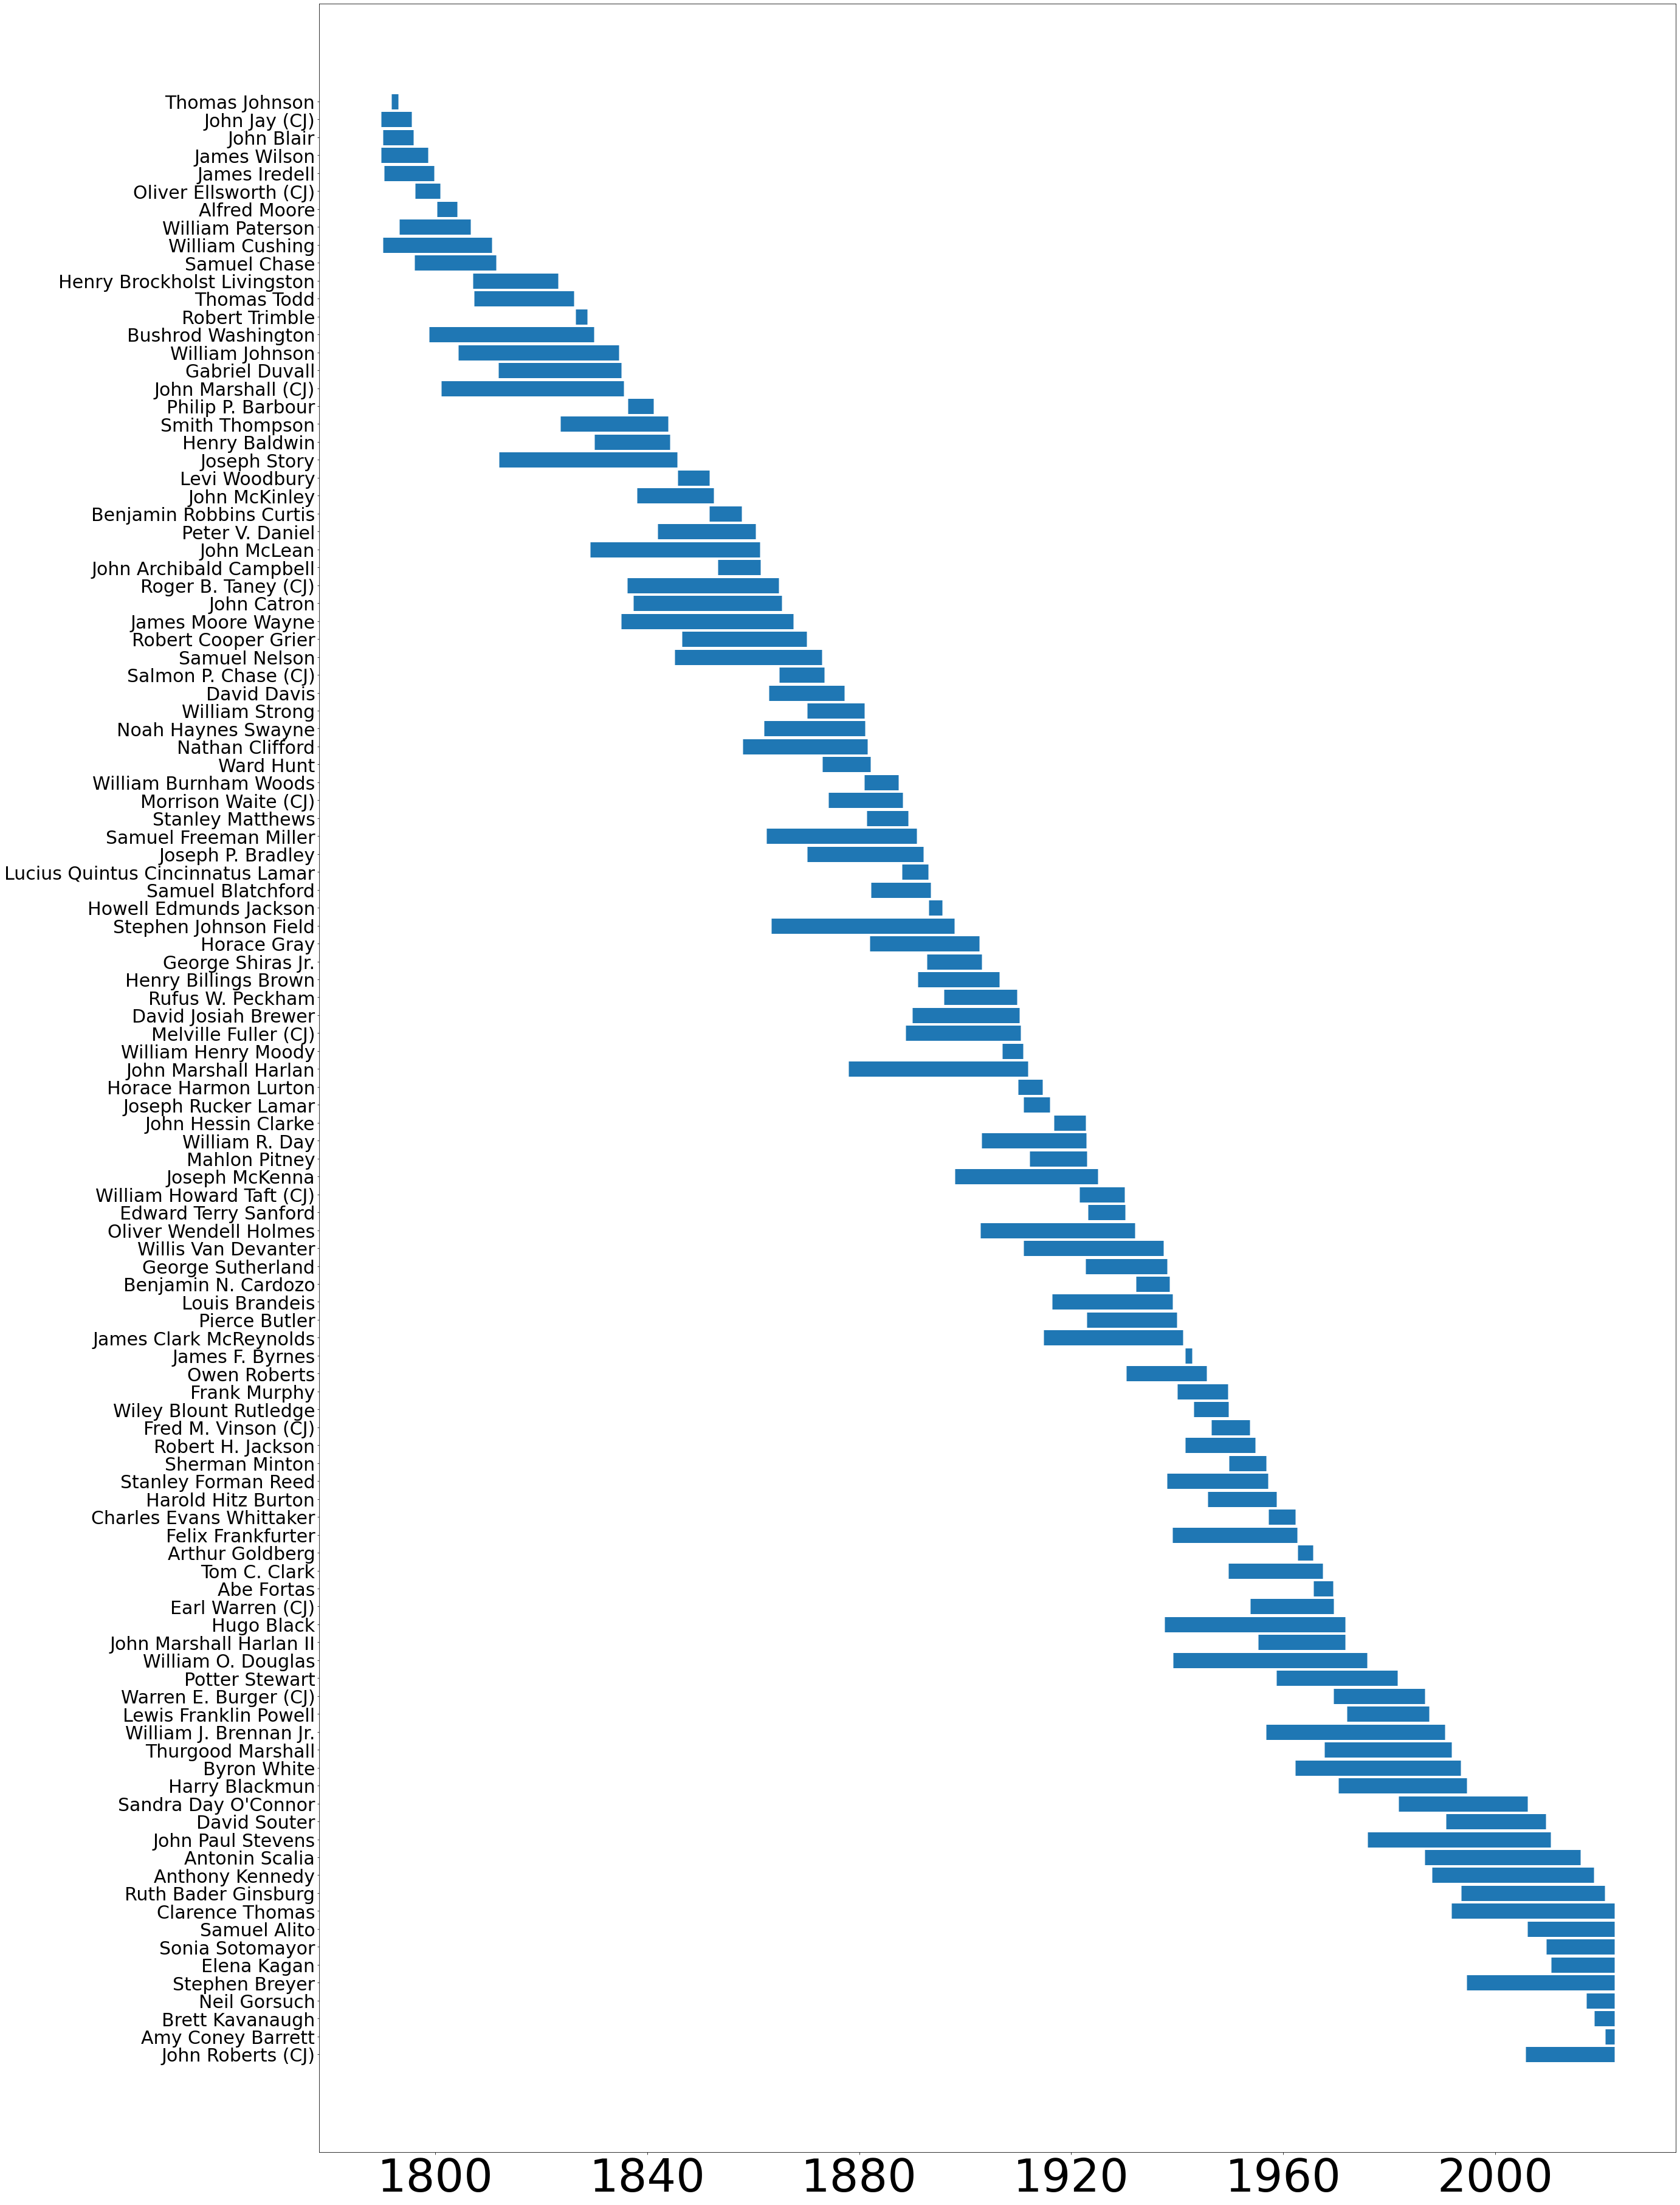

In [106]:
formatted_df = formatted_df[['start_date','end_date']]

fig, ax = plt.subplots(figsize=(40, 65))
ax = ax.xaxis_date()
ax = plt.hlines(formatted_df.index, formatted_df['start_date'], formatted_df['end_date'], linewidth=25)
ax = plt.yticks(fontsize = 30)
ax = plt.xticks(fontsize = 75)

In [113]:
# formatted_df[['start_date','end_date','b_date','d_date']]
# pd.concat([
#             formatted_df[['b_date','start_date']],
#             formatted_df[['start_date','end_date']],
#             formatted_df[['end_date','d_date']]
#             ])

formatted_df[['start_date','end_date']].rename(columns = {'start_date':'start_date', 'end_date':'end_date'}, inplace = True)
formatted_df[['b_date','d_date']].rename(columns = {'b_date':'start_date', 'd_date':'end_date'}, inplace = True)


,start_date,end_date,b_date,d_date
Justice,,,,
John Roberts (CJ),2005-09-29,2022-06-28,NaT,NaT
Amy Coney Barrett,2020-10-27,2022-06-28,NaT,NaT
Brett Kavanaugh,2018-10-06,2022-06-28,NaT,NaT
Neil Gorsuch,2017-04-10,2022-06-28,NaT,NaT
Stephen Breyer,1994-08-03,2022-06-28,NaT,NaT
...,...,...,...,...
James Iredell,NaT,NaT,1751-10-05,1751-10-20
James Wilson,NaT,NaT,NaT,NaT
John Blair,NaT,NaT,1732-04-17,1732-08-31
